# Training an MLP for FashionMNIST

To have a progress bar for training later, install tqdm and ipywidgets.
If you use conda: conda install tqdm ipywidgets

In [15]:
from typing import Tuple, Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision
import sklearn.model_selection

We can load the dataset comfortably using the torchvision library.
Data instances correspond to images of fashion articles and are labelled as one of 10 classes.

In [16]:
# load data
train_set_full = torchvision.datasets.FashionMNIST(
    "./data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
test_set = torchvision.datasets.FashionMNIST(
    "./data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)


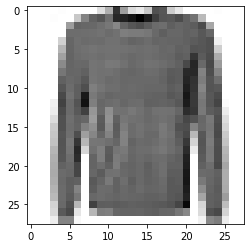

In [17]:
import matplotlib.pyplot as plt
img, target = train_set_full[231]
plt.imshow(img.view(28, 28), cmap="binary")


Since FashionMNIST only gives us a train and a test set, we split the test set further into a train and a validation set.

Q: What would happen if we used the test set instead of a validation set to tune our model?

In [18]:
val_size = 0.2
train_indices, val_indices = sklearn.model_selection.train_test_split(
    range(len(train_set_full)),
    stratify=train_set_full.targets,
    test_size=val_size,
    random_state=0,
)
train_set = torch.utils.data.Subset(train_set_full, train_indices)
val_set = torch.utils.data.Subset(train_set_full, val_indices)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=500, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=500, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=500, shuffle=False)


Now define a feedforward neural network that can process 28 by 28 images (e.g., by flattening the image into a single vector).

You can look up network components in the pytorch documentation.

In [19]:
# Define a model
class FeedForwardNet(nn.Module):
    def __init__(self, hidden_dim, out_dim=10, img_shape=(28, 28),) -> None:
        super().__init__()
        in_dim = img_shape[0] * img_shape[1]
        self.img_shape = img_shape
        self.lin1 = nn.Linear(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        """x has shape (batch_size, *img_size)"""
        x = torch.flatten(x, start_dim=1)
        x = self.lin1(x)
        x = self.act1(x)
        logits = self.lin2(x)
        return logits


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Implement the following functions that will be used in the overall training loop.

In [21]:
def train_epoch(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
) -> float:
    """Train a model for one epoch

    Args:
        model (torch.nn.Module): model to be trained
        loader (torch.utils.data.DataLoader): Dataloader for training data
        criterion (torch.nn.Module): loss function
        optimizer (torch.optim.Optimizer): optimizer

    Returns:
        float: total loss over one epoch
    """
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)  # I am using device as a global variable, but you could pass it as well
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss


@torch.no_grad()  # we dont want these operations to be recorded for automatic differentation, saves memory
def validate(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module = None,
) -> Tuple[float, float]:
    """Compute total loss and accuracy

    Args:
        model (torch.nn.Module): model to be evaluated
        loader (torch.utils.data.DataLoader): Dataloader for evaluation data
        criterion (torch.nn.Module, optional): loss function. Defaults to None.

    Returns:
        Tuple[float, float]: total loss, accuracy
    """
    total_loss = 0
    total_correct = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        if criterion is not None:
            loss = criterion(out, y)
            total_loss += loss.item()
        total_correct += (out.argmax(dim=1) == y).sum().item()
    return total_loss, total_correct / len(loader.dataset)



What accuracy can you reach on the validation set when trying out different model sizes and learning rates?

In [22]:
hidden_dim = 200
learning_rate = 1e-1

model = FeedForwardNet(hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

n_epochs = 10  # change this as needed
for epoch in range(n_epochs):
    train_epoch(model, train_loader, criterion, optimizer)
    train_loss, train_acc = validate(model, train_loader, criterion=criterion)
    val_loss, val_acc = validate(model, val_loader, criterion=criterion)
    print(
        f"{epoch=}: {train_loss=:.3f}, {train_acc=:.3f}, {val_loss=:.3f}, {val_acc=:.3f}"
    )


epoch=0: train_loss=73.922, train_acc=0.725, val_loss=18.770, val_acc=0.722
epoch=1: train_loss=60.798, train_acc=0.783, val_loss=15.457, val_acc=0.774
epoch=2: train_loss=53.770, train_acc=0.810, val_loss=13.677, val_acc=0.803
epoch=3: train_loss=51.106, train_acc=0.815, val_loss=12.951, val_acc=0.806
epoch=4: train_loss=49.621, train_acc=0.822, val_loss=12.534, val_acc=0.810
epoch=5: train_loss=46.328, train_acc=0.832, val_loss=11.807, val_acc=0.824
epoch=6: train_loss=45.944, train_acc=0.836, val_loss=11.645, val_acc=0.827
epoch=7: train_loss=47.443, train_acc=0.832, val_loss=12.077, val_acc=0.822
epoch=8: train_loss=43.161, train_acc=0.842, val_loss=10.964, val_acc=0.835
epoch=9: train_loss=42.312, train_acc=0.848, val_loss=10.862, val_acc=0.840
